# Natural Language Proessing techniques combined with autoencodes 

Author: Gabriel Rodrigues Palma

# Loaing the packages

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import numpy as np
import random
import io

import matplotlib.pyplot as plt

# Important functinos

In [2]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [3]:
def show_encodings(encoded_imgs,number=1):
    n = 5  # how many digits we will display
    original = boolean_data_train
    original = original[np.where(y_test == number)]
    encoded_imgs = encoded_imgs[np.where(y_test==number)]
    plt.figure(figsize=(20, 4))
    #plt.title('Original '+str(number)+' vs Encoded representation')
    for i in range(min(n,len(original))):
        # display original imgs
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display encoded imgs
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.tile(encoded_imgs[i],(32,1)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def compare_plot(original,decoded_imgs):
    n = 4  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(40, 56))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(40, 56))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.title('Real vs Decoded images')
    plt.show()

In [4]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

In [5]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

In [6]:
class Sampling(layers.Layer):
    
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Loading the data

In [7]:
path = keras.utils.get_file(
    "nietzsche.txt", origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt"
)
with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")  # We remove newlines chars for nicer display
print("Corpus length:", len(text))

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Corpus length: 600893
Total chars: 56
Number of sequences: 200285


/var/folders/_3/hy1xvl1s545g3884zjn6jhhm0000gn/T/ipykernel_2613/1178333198.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
/var/folders/_3/hy1xvl1s545g3884zjn6jhhm0000gn/T/ipykernel_2613/1178333198.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences)

In [8]:
print(x.shape)
print(y.shape)

(200285, 40, 56)
(200285, 56)


In [9]:
boolean_data_train = x.reshape(200285, 40 * 56)
boolean_data_train.shape

(200285, 2240)

# Creating autoencoder model

In [10]:
# Start with a sequential model
autoencoder = Sequential()

# Add a dense layer with input the original image pixels and neurons the encoded representation
autoencoder.add(Dense(32, input_shape=(2240, ), activation="relu"))

# Add an output layer with as many neurons as the orginal image pixels
autoencoder.add(Dense(2240, activation = "sigmoid"))

# Compile your model with adadelta
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy', metrics = 'accuracy')

# Summarize your model structure
autoencoder.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                71712     
                                                                 
 dense_1 (Dense)             (None, 2240)              73920     
                                                                 
Total params: 145,632
Trainable params: 145,632
Non-trainable params: 0
_________________________________________________________________


2022-06-07 09:14:39.397023: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-07 09:14:39.398121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Training the model

In [40]:
# training the model
autoencoder.fit(boolean_data_train, boolean_data_train, epochs=1)

6259/6259 [==============================] - 37s 6ms/step - loss: 0.6883 - accuracy: 8.9872e-05


# Visualizing the encoders

In [26]:
# Build your encoder by using the first layer of your autoencoder
encoder = Sequential()
encoder.add(autoencoder.layers[0])

# Encode the noisy images and show the encodings for your favorite number [0-9]
encodings = encoder.predict(boolean_data_train)
show_encodings(encodings, number = 1)

2022-06-02 19:52:09.423916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


NameError: name 'y_test' is not defined

# Visualizing the decoders

In [31]:
# Predict on the noisy images with your autoencoder
decoded_imgs = autoencoder.predict(boolean_data_train)

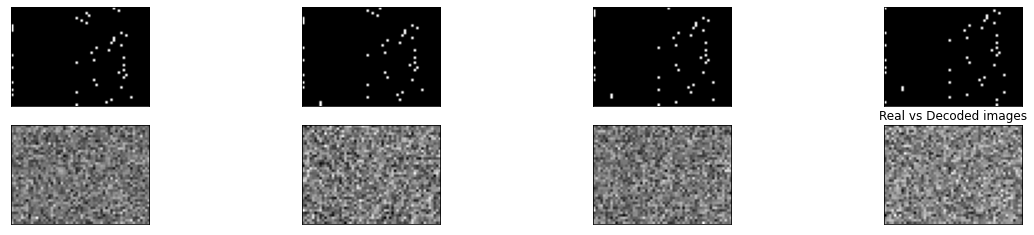

In [32]:
# Plot noisy vs decoded images
compare_plot(boolean_data_train, decoded_imgs)

# Variational autoencoders

In [38]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(40, 56, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

NameError: Exception encountered when calling layer "sampling" (type Sampling).

in user code:

    File "/var/folders/_3/hy1xvl1s545g3884zjn6jhhm0000gn/T/ipykernel_12029/2737759787.py", line 7, in call  *
        batch = tf.shape(z_mean)[0]

    NameError: name 'tf' is not defined


Call arguments received:
  • inputs=['tf.Tensor(shape=(None, 2), dtype=float32)', 'tf.Tensor(shape=(None, 2), dtype=float32)']